# Far-field Irradiance and Numerical Aperture

**Matthew Spotnitz**

**Feb 2024**

In this notebook, `cylFF.py` is first used to reproduce Figure 10.3 from "Foundations for Guided-Wave Optics" by Chin-Lin Chen (2006). Then `cylFF.py` is used to create a plot of the optical fiber emission angle for the fundamental mode for a range of core radii $a$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ofiber
import scipy.optimize
import scipy.signal

## Chen Figure 10.3

Parameters for Chen Fig. 10.3. Only the combination of $k$ and $a$, $ka = 20.3$, is specified or needed.

In [2]:
k = 1.
a = 20.3
V = 2.4
b = 0.53303

Angle in degrees at which $ka \sin \Theta = V \sqrt{1-b}$, and at which we could use Chen Eq. (10.14) instead of Eq. (10.13) to calculate `FFazim`.

In [3]:
(180/np.pi)*np.arcsin(V*np.sqrt(1-b)/(k*a))

4.63399869993096

Calculate the azimuthally integrated intensity in the far-field (Fraunhofer) limit of the fundamental mode as a function of polar angle, given the distance and fiber parameters.

The normalized intensity, $F(\theta)$, must be divided by 2 because otherwise, by using negative and positive angles, we are double counting the azimuthal integration.

In [4]:
theta_resolution = 3001
Theta = np.linspace(0,np.pi/2,theta_resolution)

ell = 0
IFF = ofiber.IrradFFxazint(R=2*np.pi,Theta=Theta,l=ell,lmbd=2*np.pi,a=a,V=V,b=b)
F = IFF/(2.*IFF[0])

Plot the intensity to reproduce Chen figure 10.3.  Specifically, create a polar plot of an azimuthally integrated function from $\Theta = -90$ to $+90$ degrees

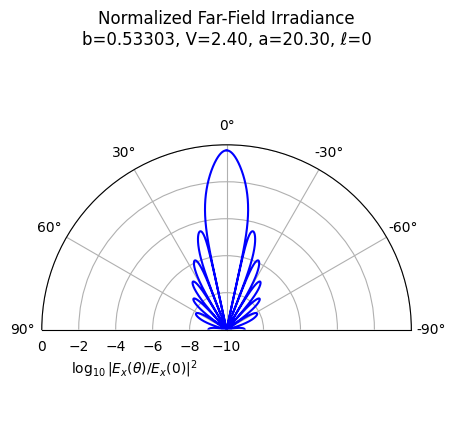

In [5]:
title = 'Normalized Far-Field Irradiance\n'
title += r'b=%.5f, V=%.2f, a=%.2f, ℓ=%d' % (b, V, a, ell)
rlabel = r'$\log_{10}|E_x(\theta)/E_x(0)|^2$'

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(Theta, np.log10(F), 'b')
ax.plot( -Theta, np.log10(F), 'b')
ax.set_theta_zero_location("N") 
ax.set_thetalim(np.pi / 2, -np.pi / 2)
ax.set_ylim(-10,0)
ax.grid(True)
ax.set_title(title)
plt.figtext(0.27, 0.2, rlabel, ha='left', va='bottom')
plt.show()

## Sweep of emission angle vs core radius $a$

### Calculate dispersion vs $a$
Calculate $V$ and $b$, for the fundamental mode $\text{LP}_{01}$, for a range of fiber core radii $a$, given $n_{\mathrm{co}}$ and $n_{\mathrm{cl}}$.

Create an array of core radii $a$ in microns ($\mu \text{m}$).

In [6]:
aRadArr = np.linspace(2,15,num=131)

Calculate the relative refractive index $\Delta$, numerical aperture NA, and generalized frequency $V$ from the core $n_{\mathrm{co}}$ and cladding $n_{\mathrm{cl}}$ refractive indices.

In [7]:
n_co = 1.589
n_cl = 1.48
# use the approximate center wavelength of the visible light spectrum, 550 nm, 
# as the free space wavelength 
lmbd0 = 0.55 
Delta = ofiber.relative_refractive_index(n_co,n_cl)
NA = ofiber.numerical_aperture_from_Delta(n_co,Delta)
Varr = ofiber.V_parameter(aRadArr,NA,lmbd0)

Initialize an empty array for the generalized guide index $b$:

In [8]:
barr = np.zeros_like(Varr)

The routine `ofiber.cylinder_step.LP_mode_value` works for the first $V$ value. We use this to find the lower bound for all remaining $b$ values. (Using a lower bound of $b=0$ in the bracketing algorithm may lead to errors.)

In [9]:
barr[0] = ofiber.LP_mode_value(V=Varr[0],ell=0,em=1)

Calculate $b$ for each $V(a)$. The routine `ofiber.cylinder_step.LP_mode_value` breaks down for very large $V$ values, so an alternate method, taking advantage of the monotonic increase of $b(V)$, is used below:

In [10]:
for i in range(1,barr.shape[-1]):
    barr[i] = (scipy.optimize.root_scalar(f=ofiber.cylinder_step._cyl_mode_eqn, args=(Varr[i], 0),bracket=(barr[i-1],1))).root

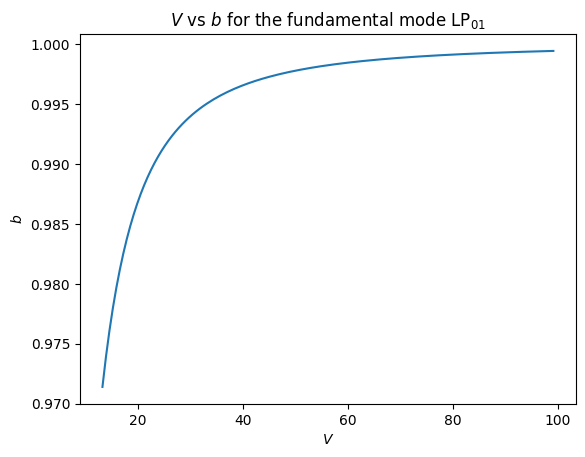

In [11]:
plt.xlabel(r'$V$')
plt.ylabel(r'$b$')
plt.plot(Varr,barr)
plt.title(r"$V$ vs $b$ for the fundamental mode $\text{LP}_{01}$")
plt.show()

### Calculate the irradiance for each $a$ and $\Theta$

Initialize an empty array for the intensity $|E_{\mathrm{FF}x}|^{2}$ with shape $(N_{\Theta},N_{a})$:

In [12]:
I_a_Theta = np.zeros((Theta.size,aRadArr.size))

Calculate the intensity vs $\Theta$ in a loop over $a$:

In [13]:
for i in range(barr.shape[-1]):
    I_a_Theta[:,i] = ofiber.IrradFFxazint(R=1,Theta=Theta,l=0,lmbd=lmbd0,a=aRadArr[i],V=Varr[i],b=barr[i]) 

### Extract the polar angle of the minimum of the central irradiance lobe for each $a$ value. 
Find the first minimum $\Theta_{01}$ of $I \propto |E_{\mathrm{FF}x}|^{2}$ when starting the search from $\Theta = 0$ and increasing. (For the fundamental mode, the first minimum is always at a nonzero $\Theta$.)

In [14]:
firstMinArr = np.zeros_like(aRadArr)

In [15]:
for i in range(aRadArr.size):
    peaks, _ = scipy.signal.find_peaks(-I_a_Theta[:,i])
    firstMinArr[i] = Theta[peaks[0]]

### Plot of emission angle vs fiber radius

Define the fit function for the angle $\Theta_{01}$ vs $a$ curve.

In this regime, an excellent fit function is $\Theta_{01}(a) = \frac{b}{a} + c$. The inverse of this fit is $\frac{b}{\Theta - c} = a$.

In [16]:
def fxinv(x, a, b):
    return a/x + b

The x-axis data is the $a$ array:

In [17]:
xdata = aRadArr

Convert $\Theta_{01}$ from radians to degrees, to ease visualization:

In [18]:
firstMinDegArr = np.multiply(firstMinArr,180/np.pi)

Fit the $x^{-1}$ function to the data:

In [19]:
popt, pcov = scipy.optimize.curve_fit(fxinv, xdata, firstMinDegArr)

Plot the emission angle calculations and the fit function:

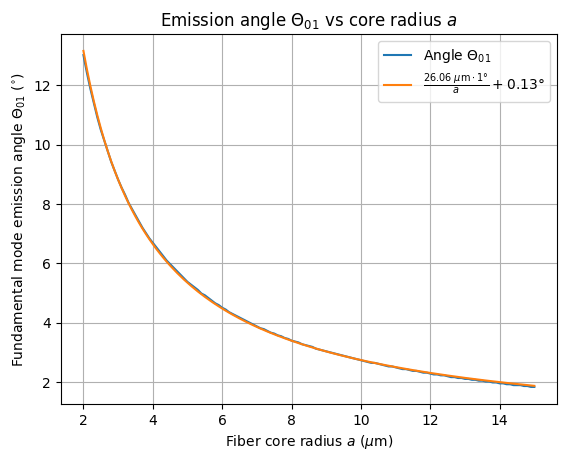

In [20]:
plt.xlabel(r'Fiber core radius $a$ ($\mu$m)')
plt.ylabel(r'Fundamental mode emission angle $\Theta_{01}$ ($^{\circ}$)')
plt.title(r'Emission angle $\Theta_{01}$ vs core radius $a$')
plt.plot(aRadArr,firstMinDegArr,label=r'Angle $\Theta_{01}$')
plt.plot(aRadArr,fxinv(xdata,popt[0],popt[1]),label=r'$\frac{%5.2f \ \mu \text{m}\cdot 1°}{a} + %5.2f°$' % tuple(popt))
plt.grid()
plt.legend()
plt.show()